# Vorbereitung

## Dependencies

In [1]:
from tensorflow import keras
import tensorflow.keras.backend as K
import tensorflow as tf
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import interpolate

## Datensätze

### Künstlichen Datensatz erzeugen

In [2]:
def target_variable(x):
    return (1/2)*x[0] - (1/4)*(x[1]**2) + (1/2)*abs(x[2])*math.sin(2*x[2]) + (1/2)*x[3]*x[4] + (1/8)*(x[4]**2)*x[5]

In [3]:
# Random Number Generator
rng = np.random.default_rng(seed=0)

# Trainingsdatensatz
## Generate Training Data x1, x3, x4, x5, x6, x7
x1_train = rng.standard_normal(size=(100000,1))
x3_7_train = rng.standard_normal(size=(100000, 5))

## Variablen x2, x8 mit 50 % Korrelation
cov_matrix = [[1, 0.5], [0.5, 1]]
x2_x8_train = rng.multivariate_normal(mean=[0, 0], cov=cov_matrix, size=100000)

# Zusammenfügen und Zielvariable berechnen
x_train = np.column_stack(
    (x1_train, x2_x8_train[:, 0], x3_7_train, x2_x8_train[:, 1]))
y_train = np.array(list(map(target_variable, x_train[:, 0:7])))


In [4]:
# Testdatensatz
## Generate Training Data x1, x3, x4, x5, x6, x7
x1_test = rng.standard_normal(size=(100000, 1))
x3_7_test = rng.standard_normal(size=(100000, 5))

## Variablen x2, x8 mit 50 % Korrelation
x2_x8_test = rng.multivariate_normal(mean=[0, 0], cov=cov_matrix, size=100000)

# Zusammenfügen und Zielvariable berechnen
x_test = np.column_stack(
    (x1_test, x2_x8_test[:, 0], x3_7_test, x2_x8_test[:, 1]))
y_test = np.array(list(map(target_variable, x_test[:, 0:7])))

In [5]:
# Check, if x2 and x8 are correlated
np.cov(x_train[:,1],x_train[:,7])

array([[0.99728065, 0.49687875],
       [0.49687875, 0.99504566]])

### Realer Datensatz

In [6]:
# french motor third party liability dataset
mtpl_df = pd.read_csv("/Users/philippknoop/Desktop/pyLocalGLMnet/data/freMTPL2freq.csv")


In [7]:
mtpl_df.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22
3,10.0,1,0.09,B,7,0,46,50,B12,Diesel,76,R72
4,11.0,1,0.84,B,7,0,46,50,B12,Diesel,76,R72


# LocalGLMnet

## Model trainieren

In [8]:
input = keras.Input(shape=(8), dtype= "float32")

In [9]:
attention = input

attention = keras.layers.Dense(units=20, activation="tanh")(attention)
attention = keras.layers.Dense(units=15, activation="tanh")(attention)
attention = keras.layers.Dense(units=10, activation="tanh")(attention)
attention = keras.layers.Dense(units=8, activation="linear", name="Attention")(attention)

2023-01-31 10:06:29.469098: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
response = keras.layers.Dot(axes=1)([input, attention])
response = keras.layers.Dense(units=1, activation="linear", name="Response")(response) 
# Wofür Dense Schicht notwendig? Ggf. um einen letzten Bias in die Funktion einzufügen
# Wenn es bspw. 8 Inputvariablen gibt und das Modell vorher die Koeffizienten a1-a8 lernt kann das Modell so zusätzlich den Intercept a0 erlernen
# Dot Layer implementiert also die eigentliche Skip Connection --> Skalarprodukt multipliziert jeweils die Einträge mit dem selben Index verschiedener Ebenen und addiert diese
# Da im Skalarprodukt der Einfluss jeder Variable enthalten ist muss um Aussage über die Feature Contribution einzelner Werte machen zu könnnen die partielle Ableitung 
# nach der entsprechenden Variable genommen werden

In [11]:
model = keras.Model(inputs=input, outputs=response)
model.compile(loss="mse", optimizer="nadam")

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           180         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 15)           315         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 10)           160         dense_1[0][0]                    
______________________________________________________________________________________________

In [13]:
history = model.fit(x_train, y_train,
          batch_size=32, epochs=10)

2023-01-31 10:06:29.813464: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
3125/3125 [==============================] - 4s 993us/step - loss: 0.1857
Epoch 2/10
3125/3125 [==============================] - 3s 971us/step - loss: 0.0519
Epoch 3/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0292
Epoch 4/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0112
Epoch 5/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0058
Epoch 6/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0047
Epoch 7/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0041
Epoch 8/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0040
Epoch 9/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0038
Epoch 10/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0037


In [14]:
print(history.history)

{'loss': [0.18566462397575378, 0.051931142807006836, 0.029223695397377014, 0.011152020655572414, 0.005843740422278643, 0.004668450448662043, 0.004091043956577778, 0.0039812191389501095, 0.0038138239178806543, 0.003668737830594182]}


## Regression Attention

In [15]:
# Über die Methode get_weights() erhält man die Kantengewichte, sowie den Bias für jeder Schicht
# --> man erhält also eine Liste mit numpy Arrays die in der Länge der Anzahl der Ebenen * 2

for i in model.get_weights():
    print(i.shape, end= " | ")

(8, 20) | (20,) | (20, 15) | (15,) | (15, 10) | (10,) | (10, 8) | (8,) | (1, 1) | (1,) | 

In [16]:
# Neues Model ohne Response-Schicht --> auslesen der Attention Schicht
weights_model = keras.Model(
    inputs=model.input, 
    outputs=model.get_layer(name="Attention").output)

# Gewichte bestimmen
beta_x = weights_model.predict(x_test)

In [17]:
# Skalierung der Attention mithilfe der Gewichte der Response Schicht (!= der tatsächlichen Vorhersage (--> beta_x liefert 8 Outputwerte, Response nur 1 Output))
beta_x = beta_x * model.get_weights()[8]

# our architecture still requires a scaling coming from dense layer ’Response’ which 
# we add to have intercept beta_0 in our LocalGLMnet architecture 
# beta.x <- beta.x * as.numeric(get_weights(model)[[9]])

# Ggf. in die Skalierung letzten Bias mit aufnehmen?
# --> beta_x = beta_x * model.get_weights()[8] + model.get_weights()[9]


## Plots

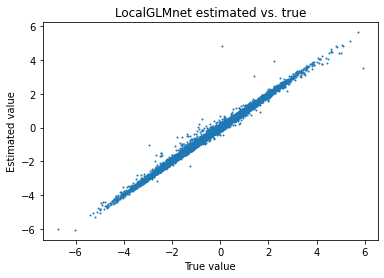

In [18]:
pred = model.predict(x_test)

plt.scatter(y_test, pred, s= 1)
plt.xlabel("True value")
plt.ylabel("Estimated value")
plt.title("LocalGLMnet estimated vs. true")
plt.show()

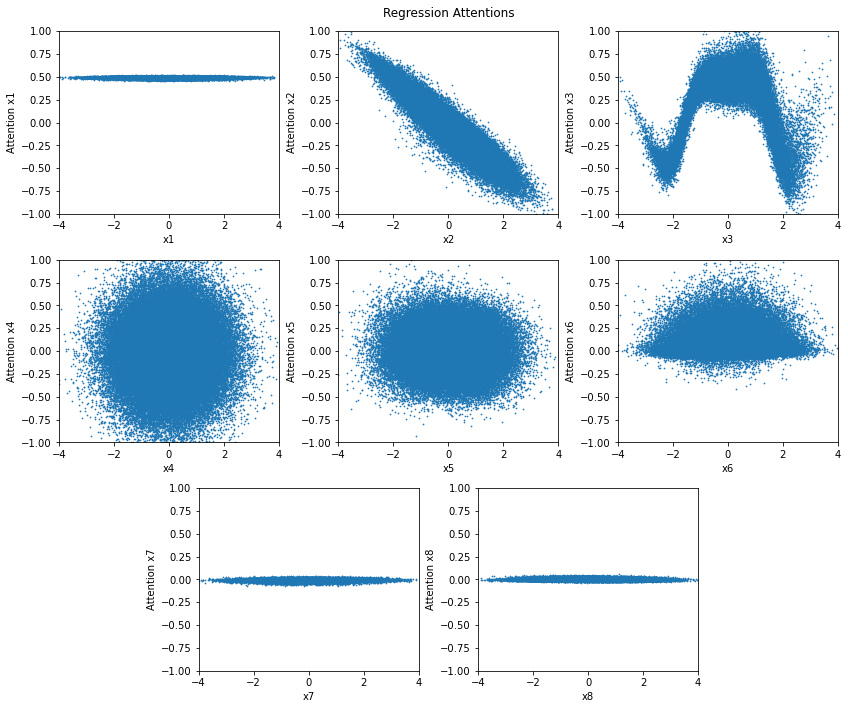

In [19]:
fig_attention = plt.figure(tight_layout=True, figsize=(15,10))

spec = GridSpec(ncols=8, nrows=3, figure=fig_attention)
ax1_att = fig_attention.add_subplot(spec[0, 1:3])
ax2_att = fig_attention.add_subplot(spec[0, 3:5])
ax3_att = fig_attention.add_subplot(spec[0, 5:7])
ax4_att = fig_attention.add_subplot(spec[1, 1:3])
ax5_att = fig_attention.add_subplot(spec[1, 3:5])
ax6_att = fig_attention.add_subplot(spec[1, 5:7])
ax7_att = fig_attention.add_subplot(spec[2, 2:4])
ax8_att = fig_attention.add_subplot(spec[2, 4:6])

axs_att = [ax1_att, ax2_att, ax3_att, ax4_att, ax5_att, ax6_att, ax7_att, ax8_att]

for i in range(len(axs_att)):
    axs_att[i].scatter(x_test[:, i],
                     beta_x[:, i], s=0.5)
    axs_att[i].set_xlim((-4, 4))
    axs_att[i].set_ylim((-1, 1))
    axs_att[i].set_xlabel('x'+str(i+1))
    axs_att[i].set_ylabel('Attention x'+str(i+1))

fig_attention.suptitle("Regression Attentions")
plt.show()


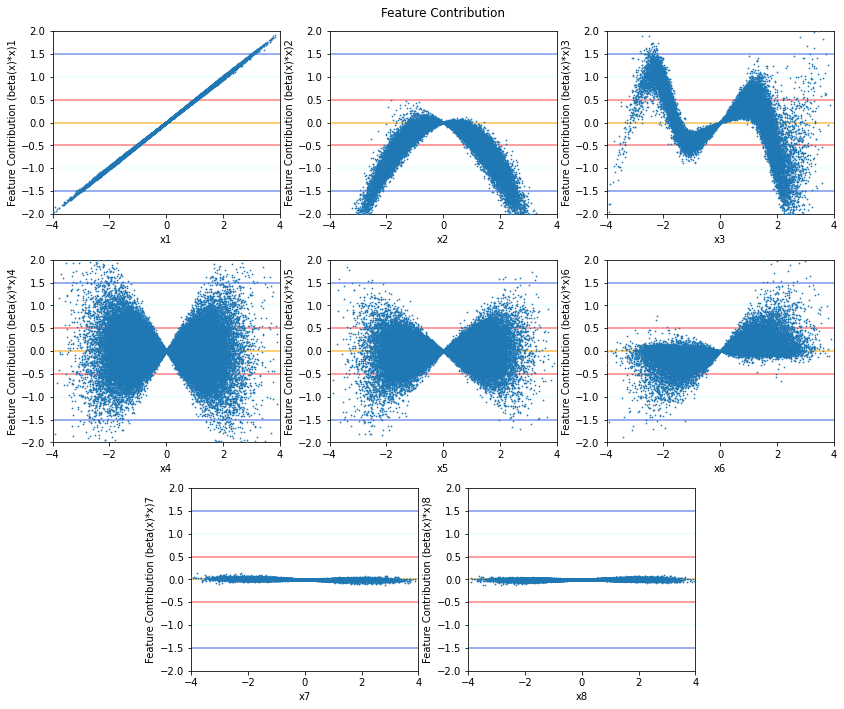

In [20]:
# Feature Contribution = beta(xi)*xi
fig_contribution = plt.figure(tight_layout=True, figsize=(15,10))

spec = GridSpec(ncols=8, nrows=3, figure=fig_contribution)
ax1_con = fig_contribution.add_subplot(spec[0, 1:3])
ax2_con = fig_contribution.add_subplot(spec[0, 3:5])
ax3_con = fig_contribution.add_subplot(spec[0, 5:7])
ax4_con = fig_contribution.add_subplot(spec[1, 1:3])
ax5_con = fig_contribution.add_subplot(spec[1, 3:5])
ax6_con = fig_contribution.add_subplot(spec[1, 5:7])
ax7_con = fig_contribution.add_subplot(spec[2, 2:4])
ax8_con = fig_contribution.add_subplot(spec[2, 4:6])

axs_con = [ax1_con, ax2_con, ax3_con, ax4_con, ax5_con, ax6_con, ax7_con, ax8_con]

for i in range(len(axs_con)):
    
    # Hinzufügen von horizontalen Linien um die Stärke der Feature Contribution zu visualisieren
    # Alpha --> Opacity
    # zorder --> horizontale Linien im Hintergrund/hinter eigentlichem Plot
    axs_con[i].hlines(y=0,xmin=-4,xmax=4, colors="orange",alpha=0.7,zorder=1)

    axs_con[i].hlines(y=0.5,xmin=-4,xmax=4, colors="red",alpha=0.5,zorder=1)
    axs_con[i].hlines(y=-0.5,xmin=-4,xmax=4, colors="red",alpha=0.5,zorder=1)

    axs_con[i].hlines(y=1,xmin=-4,xmax=4, colors="lightcyan",alpha=0.7,zorder=1)
    axs_con[i].hlines(y=-1,xmin=-4,xmax=4, colors="lightcyan",alpha=0.7,zorder=1)

    axs_con[i].hlines(y=1.5,xmin=-4,xmax=4, colors="royalblue",alpha=0.7,zorder=1)
    axs_con[i].hlines(y=-1.5,xmin=-4,xmax=4, colors="royalblue",alpha=0.7,zorder=1)

    # Scatter Plot --> x: Werte der Inputfeatures, y:Feature Contribution (β(x)*x)
    axs_con[i].scatter(x_test[:, i],
                     beta_x[:, i]*x_test[:, i], s=0.5,zorder=10)

    axs_con[i].set_xlim((-4, 4))
    axs_con[i].set_ylim((-2, 2))
    axs_con[i].set_xlabel('x'+str(i+1))
    axs_con[i].set_ylabel('Feature Contribution (beta(x)*x)'+str(i+1))

fig_contribution.suptitle("Feature Contribution")
plt.show()

### Spline Fits

#### Beta 0

In [21]:
# Model das bis zum Attention Layer geht
# Durch beta0 wird lediglich ein Attention Wert ausgegeben (in diesem Fall Attention(x0))
beta_0 = attention
beta_0 = keras.layers.Lambda(lambda x: x[:,0])(beta_0)
model_0 = keras.Model(inputs = input, outputs = beta_0)
model_0.compile(loss="mse", optimizer="nadam")


In [22]:
model_0.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense (Dense)                (None, 20)                180       
_________________________________________________________________
dense_1 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                160       
_________________________________________________________________
Attention (Dense)            (None, 8)                 88        
_________________________________________________________________
lambda (Lambda)              (None,)                   0         
Total params: 743
Trainable params: 743
Non-trainable params: 0
_____________________________________________________________

In [23]:
# Da das Model_0 die gleichen Parameter wie Model verwendet kann Call aufgerufen werden
# Liefert den Einfluss der unterschiedlichen Variablen auf die jeweilige Attention (Δβj(x)/Δx) --> Δβ0(x)/Δx
x = tf.constant(x_train)
with tf.GradientTape() as g:
    g.watch(x)
    attention0 = model_0.call(x)
d_attention0_dx = g.gradient(attention0, x)


In [24]:
d_attention0_dx

<tf.Tensor: shape=(100000, 8), dtype=float64, numpy=
array([[-1.86888356e-04,  4.40155715e-03,  1.41697936e-04, ...,
        -2.53251335e-03, -1.69027175e-04, -1.48434381e-04],
       [-3.38259706e-05,  4.90247319e-03,  8.94527696e-03, ...,
        -4.54650633e-03, -5.30705263e-04, -2.34255232e-04],
       [-1.56737442e-04,  2.51222937e-03,  5.76966675e-04, ...,
        -2.18404387e-03, -1.55940303e-04, -1.61483855e-04],
       ...,
       [-5.89626579e-05,  3.97757813e-03,  3.48478556e-04, ...,
        -2.19681533e-03, -1.93784028e-04, -2.57215317e-04],
       [ 1.15215880e-04,  4.04383056e-03,  1.26901725e-02, ...,
        -3.75845027e-03, -4.69783088e-04, -2.76911014e-04],
       [-8.17277614e-05,  3.40219308e-03,  4.76002321e-03, ...,
        -1.43692060e-03, -6.87621796e-05, -2.77665211e-04]])>

In [25]:
#Δβ0(x)/Δx0
d_attention0_dx[:,0]

<tf.Tensor: shape=(100000,), dtype=float64, numpy=
array([-1.86888356e-04, -3.38259706e-05, -1.56737442e-04, ...,
       -5.89626579e-05,  1.15215880e-04, -8.17277614e-05])>

In [26]:
# Array containing both the feature value of x0 aswell as the corresponding value of βk(x)
x0_y = np.column_stack((x[:,0].numpy(), d_attention0_dx.numpy()))
ind = np.lexsort((x0_y[:,2],x0_y[:,0]))
x0_y_sorted = x0_y[ind]

In [29]:
spline0_1 = interpolate.UnivariateSpline(x0_y_sorted[:,0],x0_y_sorted[:,1])
spline0_2 = interpolate.UnivariateSpline(x0_y_sorted[:,0],x0_y_sorted[:,2])
spline0_3 = interpolate.UnivariateSpline(x0_y_sorted[:,0],x0_y_sorted[:,3])
spline0_4 = interpolate.UnivariateSpline(x0_y_sorted[:,0],x0_y_sorted[:,4])
spline0_5 = interpolate.UnivariateSpline(x0_y_sorted[:,0],x0_y_sorted[:,5])
spline0_6 = interpolate.UnivariateSpline(x0_y_sorted[:,0],x0_y_sorted[:,6])
spline0_7 = interpolate.UnivariateSpline(x0_y_sorted[:,0],x0_y_sorted[:,7])
spline0_8 = interpolate.UnivariateSpline(x0_y_sorted[:,0],x0_y_sorted[:,8])

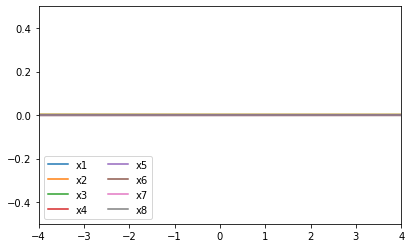

In [60]:
xs = np.linspace(-4, 4,100)
fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(xs, spline0_1(xs), label="x1")
ax.plot(xs, spline0_2(xs), label="x2")
ax.plot(xs, spline0_3(xs), label="x3")
ax.plot(xs, spline0_4(xs), label="x4")
ax.plot(xs, spline0_5(xs), label="x5")
ax.plot(xs, spline0_6(xs), label="x6")
ax.plot(xs, spline0_7(xs), label="x7")
ax.plot(xs, spline0_8(xs), label="x8")


ax.set_xlim(-4, 4,1)
ax.set_ylim(-0.5,0.5)
ax.legend(loc='lower left', ncol=2)
plt.show()

#### Beta 1

In [31]:
# Model das bis zum Attention Layer geht
# Durch beta0 wird lediglich ein Attention Wert ausgegeben (in diesem Fall Attention(x0))
beta_1 = attention
beta_1 = keras.layers.Lambda(lambda x: x[:,1])(beta_1)
model_1 = keras.Model(inputs = input, outputs = beta_1)
model_1.compile(loss="mse", optimizer="nadam")

In [32]:
x = tf.constant(x_train)
with tf.GradientTape() as g:
    g.watch(x)
    attention1 = model_1.call(x)
d_attention1_dx = g.gradient(attention1, x)

In [33]:
# Array containing both the feature value of x0 aswell as the corresponding value of βk(x)
x1_y = np.column_stack((x[:,1].numpy(), d_attention1_dx.numpy()))
ind = np.lexsort((x1_y[:,2],x1_y[:,0]))
x1_y_sorted = x1_y[ind]

In [34]:
spline1_1 = interpolate.UnivariateSpline(x1_y_sorted[:,0],x1_y_sorted[:,1])
spline1_2 = interpolate.UnivariateSpline(x1_y_sorted[:,0],x1_y_sorted[:,2])
spline1_3 = interpolate.UnivariateSpline(x1_y_sorted[:,0],x1_y_sorted[:,3])
spline1_4 = interpolate.UnivariateSpline(x1_y_sorted[:,0],x1_y_sorted[:,4])
spline1_5 = interpolate.UnivariateSpline(x1_y_sorted[:,0],x1_y_sorted[:,5])
spline1_6 = interpolate.UnivariateSpline(x1_y_sorted[:,0],x1_y_sorted[:,6])
spline1_7 = interpolate.UnivariateSpline(x1_y_sorted[:,0],x1_y_sorted[:,7])
spline1_8 = interpolate.UnivariateSpline(x1_y_sorted[:,0],x1_y_sorted[:,8])

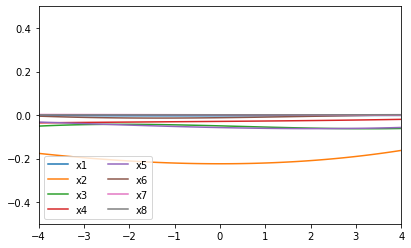

In [35]:
xs = np.linspace(-4, 4,100)
fig, ax = plt.subplots(figsize=(6.5, 4))
#ax.plot(x0_y_sorted[:,0],x0_y_sorted[:,1], 'o', label='data')
ax.plot(xs, spline1_1(xs), label="x1")
ax.plot(xs, spline1_2(xs), label="x2")
ax.plot(xs, spline1_3(xs), label="x3")
ax.plot(xs, spline1_4(xs), label="x4")
ax.plot(xs, spline1_5(xs), label="x5")
ax.plot(xs, spline1_6(xs), label="x6")
ax.plot(xs, spline1_7(xs), label="x7")
ax.plot(xs, spline1_8(xs), label="x8")

ax.set_xlim(-4, 4,1)
ax.set_ylim(-0.5,0.5)
ax.legend(loc='lower left', ncol=2)
plt.show()

#### Beta 2

In [36]:
# Model das bis zum Attention Layer geht
# Durch beta0 wird lediglich ein Attention Wert ausgegeben (in diesem Fall Attention(x0))
beta_2 = attention
beta_2 = keras.layers.Lambda(lambda x: x[:,2])(beta_2)
model_2 = keras.Model(inputs = input, outputs = beta_2)
model_2.compile(loss="mse", optimizer="nadam")

In [37]:
x = tf.constant(x_train)
with tf.GradientTape() as g:
    g.watch(x)
    attention2 = model_2.call(x)
d_attention2_dx = g.gradient(attention2, x)

In [38]:
# Array containing both the feature value of x0 aswell as the corresponding value of βk(x)
x2_y = np.column_stack((x[:,2].numpy(), d_attention2_dx.numpy()))
ind = np.lexsort((x2_y[:,2],x2_y[:,0]))
x2_y_sorted = x2_y[ind]

In [57]:
spline2_1 = interpolate.UnivariateSpline(x2_y_sorted[:,0],x2_y_sorted[:,1])
spline2_2 = interpolate.UnivariateSpline(x2_y_sorted[:,0],x2_y_sorted[:,2])
spline2_3 = interpolate.UnivariateSpline(x2_y_sorted[:,0],x2_y_sorted[:,3])
spline2_4 = interpolate.UnivariateSpline(x2_y_sorted[:,0],x2_y_sorted[:,4])
spline2_5 = interpolate.UnivariateSpline(x2_y_sorted[:,0],x2_y_sorted[:,5])
spline2_6 = interpolate.UnivariateSpline(x2_y_sorted[:,0],x2_y_sorted[:,6])
spline2_7 = interpolate.UnivariateSpline(x2_y_sorted[:,0],x2_y_sorted[:,7])
spline2_8 = interpolate.UnivariateSpline(x2_y_sorted[:,0],x2_y_sorted[:,8])

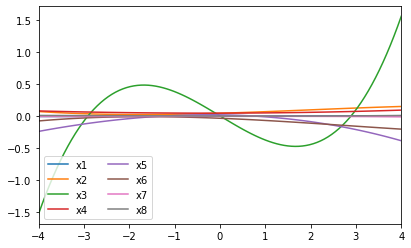

In [58]:
xs = np.linspace(-4, 4,100)
fig, ax = plt.subplots(figsize=(6.5, 4))
#ax.plot(x0_y_sorted[:,0],x0_y_sorted[:,1], 'o', label='data')
ax.plot(xs, spline2_1(xs), label="x1")
ax.plot(xs, spline2_2(xs), label="x2")
ax.plot(xs, spline2_3(xs), label="x3")
ax.plot(xs, spline2_4(xs), label="x4")
ax.plot(xs, spline2_5(xs), label="x5")
ax.plot(xs, spline2_6(xs), label="x6")
ax.plot(xs, spline2_7(xs), label="x7")
ax.plot(xs, spline2_8(xs), label="x8")

ax.set_xlim(-4, 4,1)
#ax.set_ylim(-0.5,0.5)
ax.legend(loc='lower left', ncol=2)
plt.show()

In [ ]:
fig_spline = plt.figure(tight_layout=True, figsize=(15,10))

spec = GridSpec(ncols=8, nrows=3, figure=fig_spline)
ax1_sp = fig_spline.add_subplot(spec[0, 1:3])
ax2_sp = fig_spline.add_subplot(spec[0, 3:5])
ax3_sp = fig_spline.add_subplot(spec[0, 5:7])
ax4_sp = fig_spline.add_subplot(spec[1, 1:3])
ax5_sp = fig_spline.add_subplot(spec[1, 3:5])
ax6_sp = fig_spline.add_subplot(spec[1, 5:7])
ax7_sp = fig_spline.add_subplot(spec[2, 2:4])
ax8_sp = fig_spline.add_subplot(spec[2, 4:6])

axs_sp = [ax1_sp, ax2_sp, ax3_sp, ax4_sp, ax5_sp, ax6_sp, ax7_sp, ax8_sp]

for i in range(len(axs)):
    
    axs_sp[i].hlines(y=0,xmin=-4,xmax=4, colors="orange",alpha=0.7,zorder=1)

    axs_sp[i].hlines(y=0.5,xmin=-4,xmax=4, colors="red",alpha=0.5,zorder=1)
    axs_sp[i].hlines(y=-0.5,xmin=-4,xmax=4, colors="red",alpha=0.5,zorder=1)

    axs_sp[i].hlines(y=1,xmin=-4,xmax=4, colors="lightcyan",alpha=0.7,zorder=1)
    axs_sp[i].hlines(y=-1,xmin=-4,xmax=4, colors="lightcyan",alpha=0.7,zorder=1)

    axs_sp[i].hlines(y=1.5,xmin=-4,xmax=4, colors="royalblue",alpha=0.7,zorder=1)
    axs_sp[i].hlines(y=-1.5,xmin=-4,xmax=4, colors="royalblue",alpha=0.7,zorder=1)

    # Scatter Plot --> x: Werte der Inputfeatures, y:Feature spline (β(x)*x)
    axs_sp[i].scatter(x_test[:, i],
                     beta_x[:, i]*x_test[:, i], s=0.5,zorder=10)

    axs_sp[i].set_xlim((-4, 4))
    axs_sp[i].set_ylim((-2, 2))
    axs_sp[i].set_xlabel('x'+str(i+1))
    axs_sp[i].set_ylabel('Feature spline (beta(x)*x)'+str(i+1))

fig_spline.suptitle("Feature spline")
plt.show()